In [2]:
# Import functions from the modules
from modules.data_preparation import process_dataset_testing, process_dataset_training, authenticate_kaggle,  download_dataset
from modules.model import build_model, load_model
from modules.training import train_model, train_model_k_fold
from modules.visualization import visualize_results
from modules.test import evaluate_model_on_test_set, evaluate_model_on_test_set_w_confusion

In [3]:
import torch

In [4]:
dataset_name = "oluwaseunad/concrete-and-pavement-crack-images"
dataset_zip_path = "data/D2"

In [ ]:
# Download the dataset
authenticate_kaggle()
download_dataset(dataset_name, dataset_zip_path)

In [ ]:
# Process the dataset
dataloader, class_names = process_dataset_testing(dataset_zip_path, subset_fraction=1)

In [9]:
# Build the model based on trained parameters from D1
model_path = 'CNN_models/D1_params.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, criterion, optimizer, exp_lr_scheduler = build_model()
model = load_model(model_path, device)

In [13]:
dataloader.dataset

Dataset ImageFolder
    Number of datapoints: 30000
    Root location: data/D2
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

Test Accuracy: 0.7910
Test Precision: 0.8274
Test Recall: 0.7910
Test F1-Score: 0.7851
True Positives (TP): 9365
False Positives (FP): 634
True Negatives (TN): 14366
False Negatives (FN): 5635


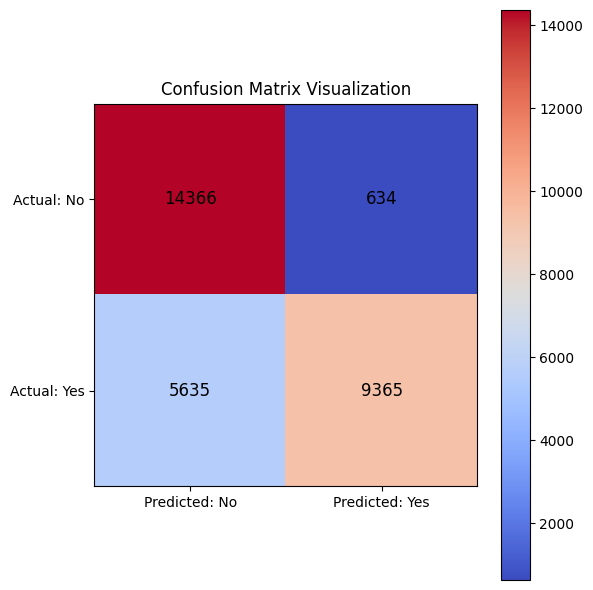

In [10]:
accuracy, precision, recall, f1, all_labels, all_preds = evaluate_model_on_test_set_w_confusion(model, dataloader, device)

In [5]:
# Step 5: Train the model
train_loader, val_loader, test_loader = dataloaders.values()

#############################################################
# Train with k folds
#############################################################
# model, results = train_model_k_fold(model,
#                    dataloaders,
#                    criterion,
#                    k = 2,
#                    num_epochs = 2,
#                    batch_size = 32,
#                    device='cpu')



#############################################################
# Train with no folds
#############################################################
model, best_acc, results = train_model(
            model = model, 
            criterion = criterion,
            optimizer = optimizer, 
            scheduler = exp_lr_scheduler,
            dataloaders = dataloaders,
            dataset_sizes = dataset_sizes,
            device =  device,
            num_epochs = 3,
            params_file = "params.pt")


Epoch 0/2
----------
train Loss: 0.6854 Acc: 0.5581
val Loss: 0.6723 Acc: 0.6600
Precision: 0.6607, Recall: 0.6600, F1-Score: 0.6594
Saving best model weights to CNN_models/params.pt...
Epoch 1/2
----------
train Loss: 0.6642 Acc: 0.6119
val Loss: 0.6485 Acc: 0.6378
Precision: 0.6451, Recall: 0.6378, F1-Score: 0.6323
Epoch 2/2
----------
train Loss: 0.6397 Acc: 0.6305
val Loss: 0.6361 Acc: 0.6356
Precision: 0.6373, Recall: 0.6356, F1-Score: 0.6339
Training complete in 2m 24s
Best val Acc: 0.660000


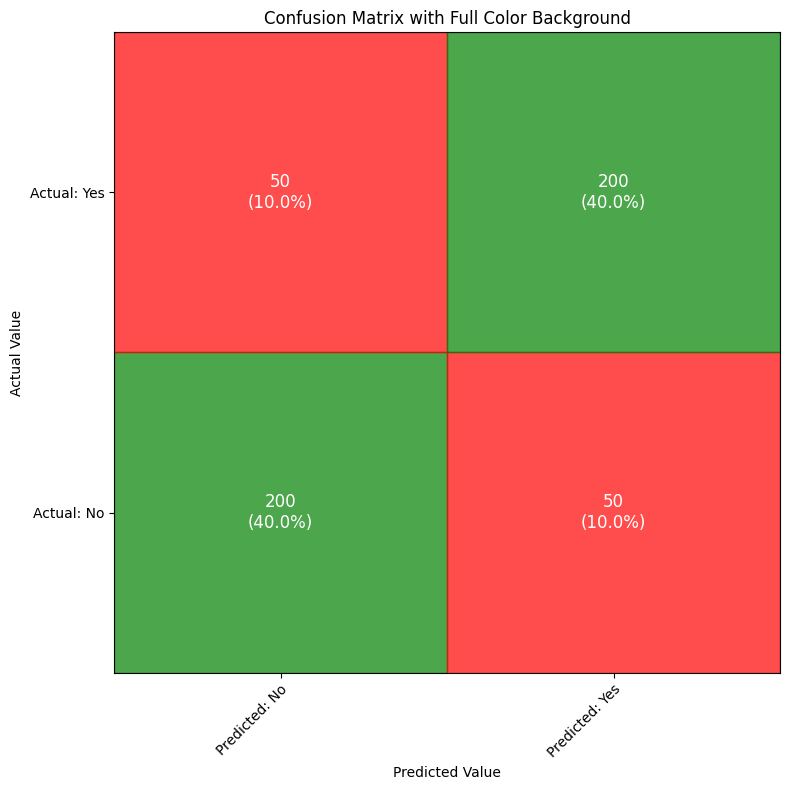

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_full_background_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot an enhanced confusion matrix with actual counts and percentages,
    highlighting TP/TN cells in full green and FP/FN cells in full red.

    Args:
        y_true (list or np.array): True labels.
        y_pred (list or np.array): Predicted labels.
        class_names (list): List of class names (e.g., ['Positive', 'Negative']).
    """
    cm = confusion_matrix(y_true, y_pred)
    total_samples = np.sum(cm)  # Total samples in the dataset

    # Calculate percentages relative to the entire dataset
    cm_percentage = cm / total_samples * 100

    fig, ax = plt.subplots(figsize=(8, 8))

    # Colors: Green for TP/TN, Red for FP/FN
    colors = np.array([
        ["green" if i == j else "red" for j in range(cm.shape[1])]
        for i in range(cm.shape[0])
    ])

    # Plot the confusion matrix with full background colors
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=colors[i, j], alpha=0.7))

            # Display counts and percentages
            count_text = f"{cm[i, j]}"  # Actual count
            percent_text = f"\n({cm_percentage[i, j]:.1f}%)"  # Percentage
            text_color = "white" if colors[i, j] in ["green", "red"] else "black"
            ax.text(j, i, count_text + percent_text, ha="center", va="center", color=text_color, fontsize=12)

    # Set labels and ticks
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=[f'Predicted: {cls}' for cls in class_names],
        yticklabels=[f'Actual: {cls}' for cls in class_names],
        title="Confusion Matrix with Full Color Background",
        ylabel="Actual Value",
        xlabel="Predicted Value",
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Draw grid and finalize layout
    ax.set_xlim(-0.5, cm.shape[1] - 0.5)
    ax.set_ylim(-0.5, cm.shape[0] - 0.5)
    ax.grid(False)
    fig.tight_layout()

    plt.show()


# Example usage
y_true = [0, 0, 1, 1, 0, 1, 0, 0, 1, 1] * 50  # Replace with your actual labels
y_pred = [0, 1, 1, 1, 0, 0, 0, 0, 1, 1] * 50  # Replace with your actual predictions
class_names = ["No", "Yes"]  # Replace with your class names

plot_full_background_confusion_matrix(y_true, y_pred, class_names)


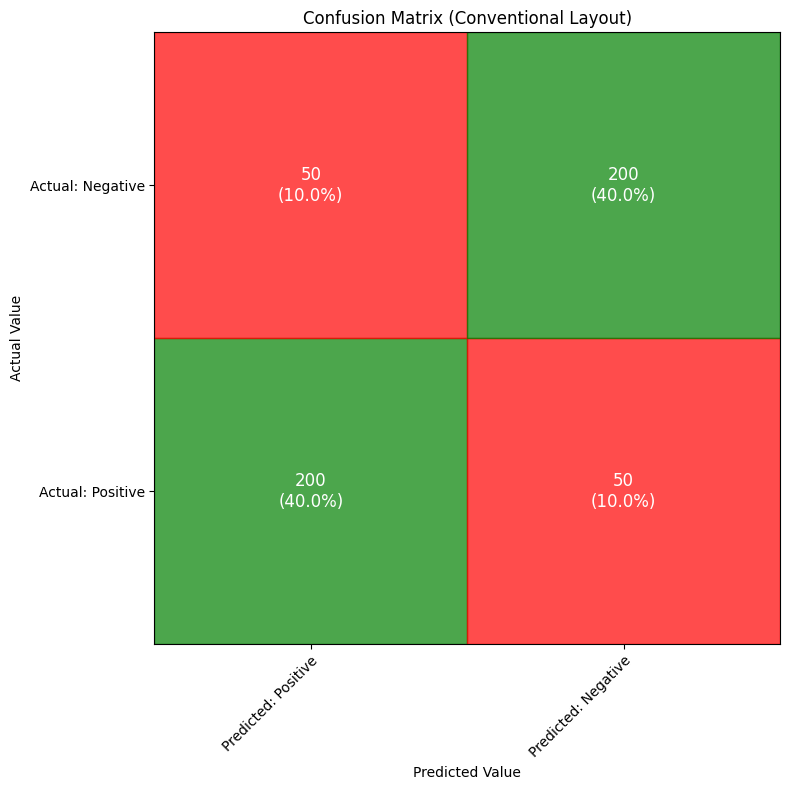

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_full_background_confusion_matrix_conventional(y_true, y_pred, class_names):
    """
    Plot an enhanced confusion matrix with actual counts and percentages,
    following the conventional layout where:
        - TP: Top-left
        - TN: Bottom-right
        - FP: Top-right
        - FN: Bottom-left

    Args:
        y_true (list or np.array): True labels.
        y_pred (list or np.array): Predicted labels.
        class_names (list): List of class names (e.g., ['Positive', 'Negative']).
    """
    cm = confusion_matrix(y_true, y_pred)
    total_samples = np.sum(cm)  # Total samples in the dataset

    # Calculate percentages relative to the entire dataset
    cm_percentage = cm / total_samples * 100

    fig, ax = plt.subplots(figsize=(8, 8))

    # Colors: Green for TP/TN, Red for FP/FN
    colors = np.array([
        ["green", "red"],  # Top-left: TP, Top-right: FP
        ["red", "green"]   # Bottom-left: FN, Bottom-right: TN
    ])

    # Plot the confusion matrix with full background colors
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=colors[i, j], alpha=0.7))

            # Display counts and percentages
            count_text = f"{cm[i, j]}"  # Actual count
            percent_text = f"\n({cm_percentage[i, j]:.1f}%)"  # Percentage
            text_color = "white"
            ax.text(j, i, count_text + percent_text, ha="center", va="center", color=text_color, fontsize=12)

    # Set labels and ticks
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=[f'Predicted: {cls}' for cls in class_names],
        yticklabels=[f'Actual: {cls}' for cls in class_names],
        title="Confusion Matrix (Conventional Layout)",
        ylabel="Actual Value",
        xlabel="Predicted Value",
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Draw grid and finalize layout
    ax.set_xlim(-0.5, cm.shape[1] - 0.5)
    ax.set_ylim(-0.5, cm.shape[0] - 0.5)
    ax.grid(False)
    fig.tight_layout()

    plt.show()

# Example usage
y_true = [0, 0, 1, 1, 0, 1, 0, 0, 1, 1] * 50  # Replace with your actual labels
y_pred = [0, 1, 1, 1, 0, 0, 0, 0, 1, 1] * 50  # Replace with your actual predictions
class_names = ["Positive", "Negative"]  # Replace with your class names

plot_full_background_confusion_matrix_conventional(y_true, y_pred, class_names)


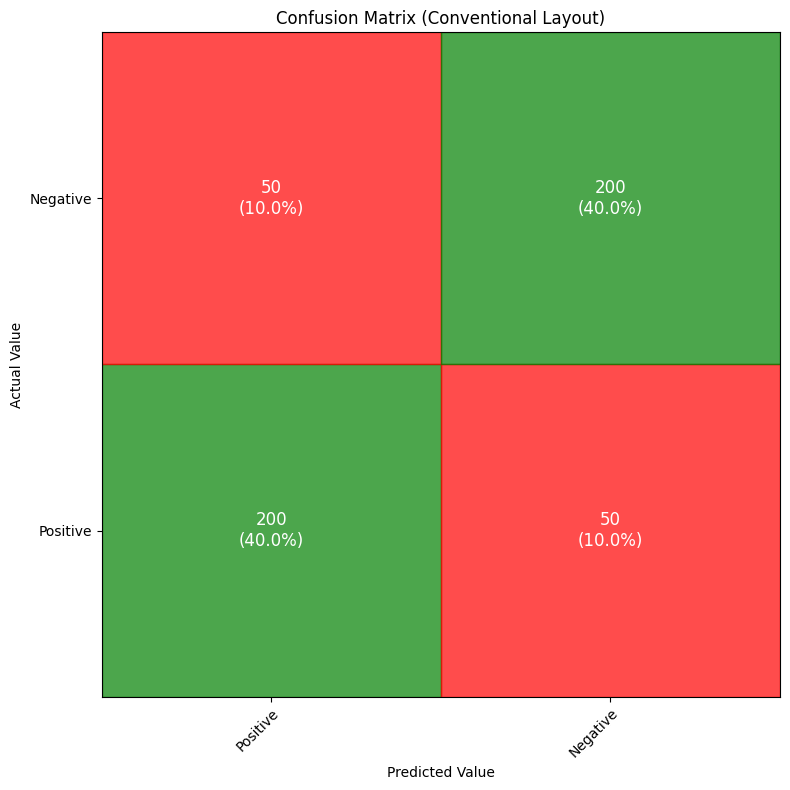

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_full_background_confusion_matrix_conventional(y_true, y_pred, class_names):
    """
    Plot an enhanced confusion matrix with actual counts and percentages,
    following the conventional layout:
        - TP: Top-left
        - FP: Top-right
        - FN: Bottom-left
        - TN: Bottom-right

    Args:
        y_true (list or np.array): True labels.
        y_pred (list or np.array): Predicted labels.
        class_names (list): List of class names (e.g., ['Positive', 'Negative']).
    """
    cm = confusion_matrix(y_true, y_pred)

    # Rearrange confusion matrix to match conventional layout
    # [[TP, FP],
    #  [FN, TN]]
    cm = np.array([[cm[1, 1], cm[0, 1]],
                   [cm[1, 0], cm[0, 0]]])
    
    total_samples = np.sum(cm)  # Total samples in the dataset

    # Calculate percentages relative to the entire dataset
    cm_percentage = cm / total_samples * 100

    fig, ax = plt.subplots(figsize=(8, 8))

    # Colors: Green for TP/TN, Red for FP/FN
    colors = np.array([
        ["green", "red"],  # Top-left: TP, Top-right: FP
        ["red", "green"]   # Bottom-left: FN, Bottom-right: TN
    ])

    # Plot the confusion matrix with full background colors
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=colors[i, j], alpha=0.7))

            # Display counts and percentages
            count_text = f"{cm[i, j]}"  # Actual count
            percent_text = f"\n({cm_percentage[i, j]:.1f}%)"  # Percentage
            text_color = "white"
            ax.text(j, i, count_text + percent_text, ha="center", va="center", color=text_color, fontsize=12)

    # Set labels and ticks
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=["Positive", "Negative"],  # Predicted
        yticklabels=["Positive", "Negative"],  # Actual
        title="Confusion Matrix (Conventional Layout)",
        ylabel="Actual Value",
        xlabel="Predicted Value",
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Draw grid and finalize layout
    ax.set_xlim(-0.5, cm.shape[1] - 0.5)
    ax.set_ylim(-0.5, cm.shape[0] - 0.5)
    ax.grid(False)
    fig.tight_layout()

    plt.show()

# Example usage
y_true = [0, 0, 1, 1, 0, 1, 0, 0, 1, 1] * 50  # Replace with your actual labels
y_pred = [0, 1, 1, 1, 0, 0, 0, 0, 1, 1] * 50  # Replace with your actual predictions
class_names = ["Positive", "Negative"]  # Replace with your class names

plot_full_background_confusion_matrix_conventional(y_true, y_pred, class_names)


In [18]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[200,  50],
       [ 50, 200]])